In [ ]:
import regex as re
import collections
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import nltk.tokenize
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.lm import MLE

In [2]:
def tokenize(text):
    # Initialise lists
    tokens = []
    
    # since we do not use unmatchable it is commented out 
    # unmatchable = []

    # Compile patterns for speedup
    
    token_pat = re.compile(r'\w+|\p{Emoji}+') # parts of words and emojis
    skippable_pat = re.compile(r'\s+')  # typically spaces
    # Analyze one line at the time as splicing big chunks of text is highly inefficient
    for line in text.split('\n'):
        # As long as there's any material left...
        while line:
            # Try finding a skippable token delimiter first.
            skippable_match = re.search(skippable_pat, line)
            if skippable_match and skippable_match.start() == 0:
                # If there is one at the beginning of the line, just skip it.
                line = line[skippable_match.end():]
            else:
                # Else try finding a real token.
                token_match = re.search(token_pat, line)
                if token_match and token_match.start() == 0:
                    # If there is one at the beginning of the line, tokenise it.
                    if line[:token_match.end()] != 'user': # skipping censored Twitter handles
                        tokens.append(line[:token_match.end()])
                    line = line[token_match.end():]
                    
                else:
                    # Else there is unmatchable material here.
                    # It ends where a skippable or token match starts, or at the end of the line.
                    unmatchable_end = len(line)
                    if skippable_match:
                        unmatchable_end = skippable_match.start()
                    if token_match:
                        unmatchable_end = min(unmatchable_end, token_match.start())
                    # Add it to unmatchable and discard from line.
                    # unmatchable.append(line[:unmatchable_end])
                    line = line[unmatchable_end:]

    return tokens

In [14]:
def freq_plot(tokens, voc, idx):
    
    
    frq = pd.DataFrame(voc.most_common(), columns=['token', 'frequency'])

    # Index in the sorted list
    frq['idx'] = frq.index + 1

    # Frequency normalised by corpus size
    frq['norm_freq'] = frq.frequency / len(tokens)

    # Cumulative normalised frequency
    frq['cumul_frq'] = frq.norm_freq.cumsum()
    
    xlabel = 'Index'
    ylabel = 'Cumulative frequency'
    
    fig, axs = plt.subplots(1, 3,figsize=(12,7))
    
    fig.suptitle(idx) 
    
    # Plot: Cumulative frequency by index
    axs[0].scatter(x='idx', y='cumul_frq', data=frq)
    axs[0].set_xlabel(xlabel)
    axs[0].set_ylabel(ylabel)

    # Plot: Cumulative frequency by index, top 10000 tokens
    axs[1].scatter(x='idx', y='cumul_frq', data=frq[:10000])
    axs[1].set_xlabel(xlabel)
    axs[1].set_ylabel(ylabel)

    # Plot: Log-log plot for Zipf's law
    frq['log_frq'] = np.log(frq.frequency)
    frq['log_rank'] = np.log(frq.frequency.rank(ascending=False))
    
    axs[2].scatter(x='log_rank', y='log_frq', data=frq)
    axs[2].set_xlabel("log(rank)")
    axs[2].set_ylabel("log(frequency)")

    
    plt.tight_layout()
    
    fig.show()
    

In [4]:
tk = nltk.tokenize.TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)

In [5]:
# each element of this dictionary is a tuple, whose first element is tokens from tokenize()
#and second is from TweetTokenizer()

tokens = dict()
counters = dict()

# indices of the above dictionaries
indices = ['offensive', 'sentiment', 'gatsby']

for idx in indices:
    if idx == 'gatsby':
        # The Great Gatsby has a different path, we also need to remove Gutenberg's header and footer
        text = open('../data/GreatGatsby.txt', 'r', encoding='utf-8').read().split('***')[2]
    else:
        text = open(f'../data/{idx}/train_text.txt', 'r', encoding='utf-8').read()
    tokens[idx] = (tokenize(text), tk.tokenize(text))
    counters[idx] = (collections.Counter(tokens[idx][0]), collections.Counter(tokens[idx][1]))
    
    print(idx.capitalize())
    print('-' * len(idx))
    
    length = len(tokens[idx][0])
    length_counter = len(counters[idx][0])
    print(f"""Our  tokenizer found {length} tokens, {length_counter} of which\
 (or {round(100 * length_counter / length, 2)}%) are unique.""")
    length = len(tokens[idx][1])
    length_counter = len(counters[idx][1])
    print(f"""TweetTokenizer found {length} tokens, {length_counter} of which\
 (or {round(100 * length_counter / length, 2)}%) are unique.\n""")

Offensive
---------
Our  tokenizer found 244967 tokens, 23624 of which (or 9.64%) are unique.
TweetTokenizer found 271264 tokens, 19736 of which (or 7.28%) are unique.

Sentiment
---------
Our  tokenizer found 901635 tokens, 56021 of which (or 6.21%) are unique.
TweetTokenizer found 1015580 tokens, 49124 of which (or 4.84%) are unique.

Gatsby
------
Our  tokenizer found 50004 tokens, 6258 of which (or 12.51%) are unique.
TweetTokenizer found 61266 tokens, 5936 of which (or 9.69%) are unique.



In [6]:
print('20 most common words\n')
for idx in indices:
    print(f'{idx.capitalize()}:')
    for rank, word in enumerate(counters[idx][0].most_common(20), 1):
        print(f'{rank}. {word[0]} - {word[1]} occurences')
    print()

20 most common words

Offensive:
1. the - 7271 occurences
2. is - 5656 occurences
3. to - 5472 occurences
4. # - 4740 occurences
5. a - 4582 occurences
6. and - 4106 occurences
7. you - 3683 occurences
8. of - 3347 occurences
9. are - 3076 occurences
10. I - 3075 occurences
11. that - 2369 occurences
12. in - 2321 occurences
13. s - 2172 occurences
14. for - 2152 occurences
15. t - 2018 occurences
16. it - 1828 occurences
17. he - 1681 occurences
18. on - 1475 occurences
19. she - 1421 occurences
20. with - 1299 occurences

Sentiment:
1. the - 34873 occurences
2. to - 20673 occurences
3. I - 15273 occurences
4. in - 13130 occurences
5. on - 12573 occurences
6. a - 12202 occurences
7. and - 12015 occurences
8. # - 11494 occurences
9. of - 10683 occurences
10. for - 9669 occurences
11. is - 9269 occurences
12. s - 8502 occurences
13. you - 7939 occurences
14. it - 7700 occurences
15. with - 7352 occurences
16. be - 7096 occurences
17. at - 6902 occurences
18. tomorrow - 6664 occurences
1

<ipython-input-14-60ac4ee5c8fd>:43: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


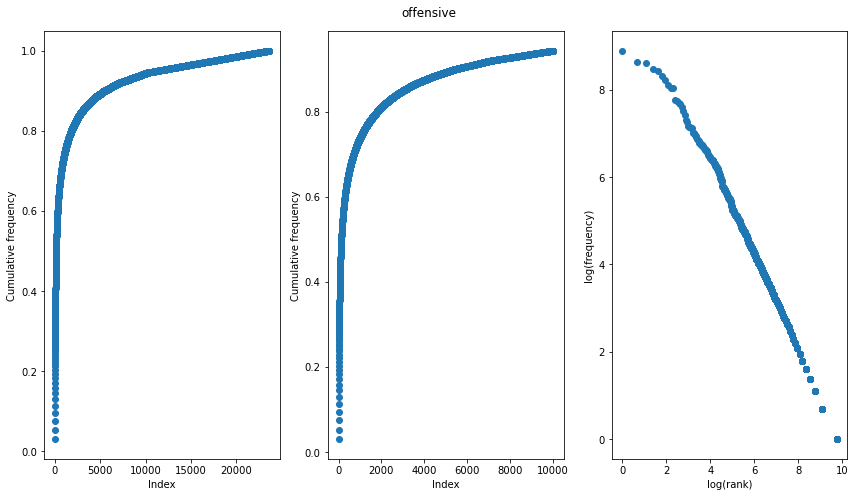

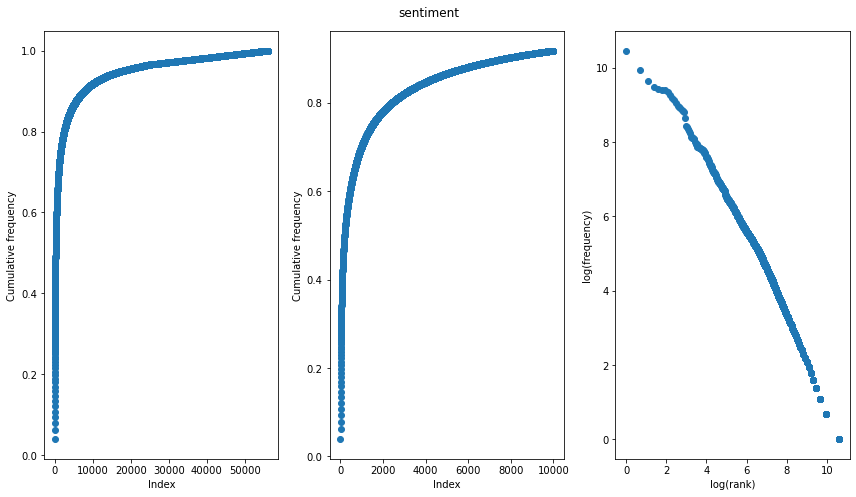

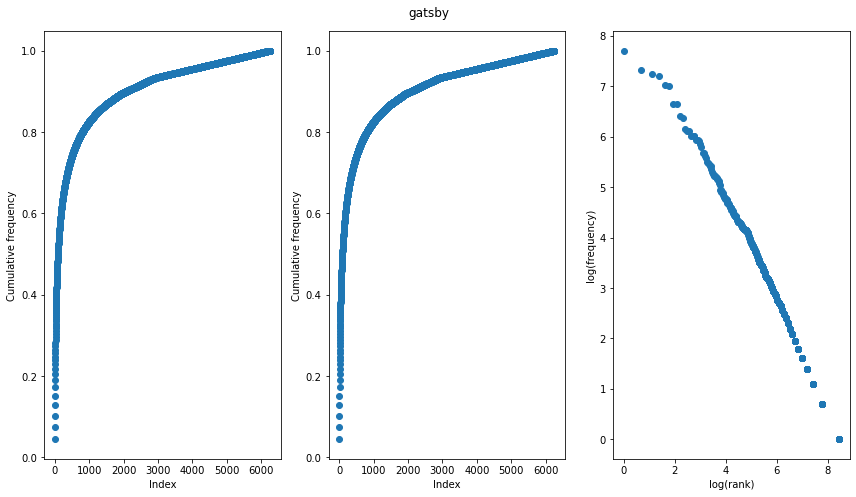

In [17]:
for idx in indices:
    freq_plot(tokens[idx][0], counters[idx][0],idx)


In [18]:
# drop gatsby
if "gatsby" in counters.keys():
    del counters["gatsby"]

if "gatsby" in tokens.keys():
    del tokens["gatsby"]    

indices = ['offensive', 'sentiment']

In [19]:
# drop list at index 1 at all tuples because tweettokenizer generated weird n-grams, for example "!" "!" "!" or "s" "u" "s"

for idx in indices:
    if type(tokens[idx]) == tuple :
        tokens[idx] = tokens[idx][0]
        
    if type(counters[idx]) == tuple :
        counters[idx] = counters[idx][0]
 
    
    

In [20]:
#Compare the most frequent words with a general word list for English
wordfre = pd.read_excel(r'../data/wordFrequency.xlsx', sheet_name='1 lemmas')
fre_words = pd.DataFrame(wordfre, columns= ['lemma'])
print("the most frequent words in general word list for English")
print(fre_words.head(20))
print()

for idx in indices:
    print(f'{idx.capitalize()}:')
    for rank, word in enumerate(counters[idx].most_common(20)):
        print(f'{rank}    {word[0]}')
    print()
        

the most frequent words in general word list for English
   lemma
0    the
1     be
2    and
3      a
4     of
5     to
6     in
7      i
8    you
9     it
10  have
11    to
12  that
13   for
14    do
15    he
16  with
17    on
18  this
19   n't

Offensive:
0    the
1    is
2    to
3    #
4    a
5    and
6    you
7    of
8    are
9    I
10    that
11    in
12    s
13    for
14    t
15    it
16    he
17    on
18    she
19    with

Sentiment:
0    the
1    to
2    I
3    in
4    on
5    a
6    and
7    #
8    of
9    for
10    is
11    s
12    you
13    it
14    with
15    be
16    at
17    tomorrow
18    may
19    that



In [21]:
xd = list(zip(tokens["offensive"], tokens["offensive"][1:]))
collections.Counter(xd).most_common(20)

[(('you', 'are'), 914),
 (('gun', 'control'), 844),
 (('he', 'is'), 823),
 (('she', 'is'), 768),
 (('is', 'a'), 715),
 (('#', 'MAGA'), 662),
 (('don', 't'), 644),
 (('of', 'the'), 590),
 (('He', 'is'), 545),
 (('She', 'is'), 531),
 (('You', 'are'), 483),
 (('in', 'the'), 480),
 (('I', 'm'), 361),
 (('to', 'be'), 346),
 (('is', 'the'), 333),
 (('it', 's'), 332),
 (('It', 's'), 297),
 (('MAGA', '#'), 295),
 (('to', 'the'), 287),
 (('on', 'the'), 284)]

In [22]:
xd = list(zip(tokens["offensive"], tokens["offensive"][1:], tokens["offensive"][2:]))
collections.Counter(xd).most_common(20)

[(('#', 'MAGA', '#'), 291),
 (('I', 'don', 't'), 167),
 (('She', 'is', 'a'), 115),
 (('He', 'is', 'a'), 98),
 (('gun', 'control', 'laws'), 90),
 (('he', 'is', 'a'), 88),
 (('she', 'is', 'a'), 81),
 (('you', 'are', 'a'), 72),
 (('for', 'gun', 'control'), 64),
 (('don', 't', 'know'), 60),
 (('You', 'are', 'a'), 55),
 (('is', 'going', 'to'), 52),
 (('you', 'don', 't'), 51),
 (('they', 'don', 't'), 51),
 (('a', 'lot', 'of'), 50),
 (('on', 'gun', 'control'), 49),
 (('about', 'gun', 'control'), 48),
 (('gun', 'control', 'and'), 48),
 (('don', 't', 'have'), 47),
 (('that', 'you', 'are'), 46)]

In [23]:
xd = list(zip(tokens["offensive"], tokens["offensive"][1:], tokens["offensive"][2:], tokens["offensive"][3:]))
collections.Counter(xd).most_common(20)

[(('#', 'MAGA', '#', 'KAG'), 39),
 (('#', 'TCOT', '#', 'MAGA'), 33),
 (('TCOT', '#', 'MAGA', '#'), 33),
 (('#', 'MAGA', '#', 'RedNationRising'), 33),
 (('I', 'don', 't', 'know'), 28),
 (('❤', '️', '❤', '️'), 26),
 (('MAGA', '#', 'KAG', '#'), 23),
 (('I', 'don', 't', 'think'), 22),
 (('common', 'sense', 'gun', 'control'), 22),
 (('🇺🇸❤', '️', '🇺🇸❤', '️'), 21),
 (('️', '🇺🇸❤', '️', '🇺🇸❤'), 19),
 (('the', 'rest', 'of', 'the'), 18),
 (('#', 'MAGA', '#', 'WWG1WGA'), 17),
 (('️', '❤', '️', '❤'), 17),
 (('when', 'it', 'comes', 'to'), 16),
 (('you', 'are', 'going', 'to'), 15),
 (('nothing', 'to', 'do', 'with'), 15),
 (('is', 'one', 'of', 'the'), 15),
 (('I', 'hope', 'you', 'are'), 14),
 (('don', 't', 'have', 'a'), 14)]

In [24]:
xd = list(zip(tokens["offensive"], tokens["offensive"][1:], tokens["offensive"][2:], tokens["offensive"][3:], tokens["offensive"][4:], tokens["offensive"][5:], tokens["offensive"][6:], tokens["offensive"][7:]))
collections.Counter(xd).most_common(20)

[(('🇺🇸❤', '️', '🇺🇸❤', '️', '🇺🇸❤', '️', '🇺🇸❤', '️'), 15),
 (('️', '🇺🇸❤', '️', '🇺🇸❤', '️', '🇺🇸❤', '️', '🇺🇸❤'), 14),
 (('#', 'Tories', '#', 'Labour', '#', 'GE2017', '#', 'Conservatives'), 9),
 (('Tories',
   '#',
   'Labour',
   '#',
   'GE2017',
   '#',
   'Conservatives',
   'Conservatives'),
  9),
 (('❤', '️', '❤', '️', '❤', '️', '❤', '️'), 8),
 (('🤦🏾', '\u200d', '♂', '️', '🤦🏾', '\u200d', '♂', '️'), 5),
 (('Looks', 'Like', 'The', 'Jokes', 'On', 'Liberals', 'Again', '#'), 5),
 (('Like', 'The', 'Jokes', 'On', 'Liberals', 'Again', '#', 'FortTrump'), 5),
 (('The', 'Jokes', 'On', 'Liberals', 'Again', '#', 'FortTrump', '#'), 5),
 (('Jokes', 'On', 'Liberals', 'Again', '#', 'FortTrump', '#', 'Poland'), 5),
 (('On', 'Liberals', 'Again', '#', 'FortTrump', '#', 'Poland', '#'), 5),
 (('Liberals',
   'Again',
   '#',
   'FortTrump',
   '#',
   'Poland',
   '#',
   'BoomingEconomy'),
  5),
 (('ANTIFA', 'with', 'their', 'KKK', 'hoods', 'beating', 'up', 'strangers'),
  5),
 (('with', 'their', 'KKK', '

In [55]:
sentences = list()
text = open(f'../data/{idx}/train_text.txt', 'r', encoding='utf-8').read().splitlines()


In [56]:
for line in text:
    sentences += (line.split("."))

In [27]:
text[1]

'"Ben Smith / Smith (concussion) remains out of the lineup Thursday, Curtis #NHL #SJ" '

In [28]:
sentences[0]

'"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts'

## data clearing 

In [62]:
new_sentences = []
for i, line in enumerate(sentences):
    to_add = tokenize(line)
    if to_add:
        new_sentences.append(to_add)

sentences = new_sentences

In [58]:
sentences

[['QT',
  'In',
  'the',
  'original',
  'draft',
  'of',
  'the',
  '7th',
  'book',
  'Remus',
  'Lupin',
  'survived',
  'the',
  'Battle',
  'of',
  'Hogwarts'],
 ['#', 'HappyBirthdayRemusLupin'],
 ['Ben',
  'Smith',
  'Smith',
  'concussion',
  'remains',
  'out',
  'of',
  'the',
  'lineup',
  'Thursday',
  'Curtis',
  '#',
  'NHL',
  '#',
  'SJ'],
 ['Sorry',
  'bout',
  'the',
  'stream',
  'last',
  'night',
  'I',
  'crashed',
  'out',
  'but',
  'will',
  'be',
  'on',
  'tonight',
  'for',
  'sure'],
 ['Then', 'back', 'to', 'Minecraft', 'in', 'pc', 'tomorrow', 'night'],
 ['Chase',
  'Headley',
  's',
  'RBI',
  'double',
  'in',
  'the',
  '8th',
  'inning',
  'off',
  'David',
  'Price',
  'snapped',
  'a',
  'Yankees',
  'streak',
  'of',
  '33',
  'consecutive',
  'scoreless',
  'innings',
  'against',
  'Blue',
  'Jays'],
 ['Alciato',
  'Bee',
  'will',
  'invest',
  '150',
  'million',
  'in',
  'January',
  'another',
  '200',
  'in',
  'the',
  'Summer',
  'and',
  'p

In [30]:
sentences[0]

['QT',
 'In',
 'the',
 'original',
 'draft',
 'of',
 'the',
 '7th',
 'book',
 'Remus',
 'Lupin',
 'survived',
 'the',
 'Battle',
 'of',
 'Hogwarts']

In [74]:
lm = [None, None]
for i in range(2, 7):
    lm.append(MLE(i))
    train, vocab = padded_everygram_pipeline(i, sentences)
    lm[i].fit(train, vocab)
    print(f'{i}\n---')
    print(lm[i].generate(10))

2
---
56024
['Picture', 'of', 'Vengeance', '</s>', 'this', 'Saturday', 'night', 'LIVE', 'at', 'Splash']
3
---
56024
['a', 'triple', 'for', 'Daniel', 'Murphy', 'as', 'a', 'Jay', 'with', '3']
4
---
56024
['barca', 'also', 'my', 'team', 'isn', 't', 'in', 'prison', '</s>', '</s>']
5
---
56024
['FALL', 'is', 'here', 'Sunday', 'School', 'starts', 'THIS', 'Sunday', 'UES', 'and']
6
---
56024
['the', 'Pride', 'Parade', 'is', 'the', 'most', 'visible', '</s>', '</s>', '</s>']


In [81]:
print(lm[2].score("car",["the"]))
print(lm[2].score("Trump",["is"]))

print(lm[2].logscore("car",["the"]))
print(lm[2].logscore("Trump",["is"]))

0.0006021850715453216
0.00010788650339842486
-10.697505436140611
-13.178197984584981


In [83]:
val = list()
text = open(f'../data/{idx}/val_text.txt', 'r', encoding='utf-8').read().splitlines()

for line in text:
    val += (line.split("."))
    
new_val= []
for i, line in enumerate(val):
    to_add = tokenize(line)
    if to_add:
        new_val.append(to_add)

val = new_val

In [93]:
perpexlity_list = [None,None,[],[],[],[],[]]
for i in range(2, 7):
    val_test, _ = padded_everygram_pipeline(i, val)
    
    for n, t in enumerate(val_test):
        print(lm[i].perplexity(t))
        

inf
inf
100.09497140075896
inf
inf
inf
inf
inf
inf
132.44023549931347
inf
inf
156.96142021666026
inf
inf
inf
inf
inf
inf
151.30143595899648
inf
181.1873853119585
inf
113.66163039439718
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
112.93134610676786
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
293.3885614286094
inf
107.29177806580451
inf
412.2706793296604
34.143818870492034
121.82738286165241
216.9576643503375
inf
inf
inf
223.6175298967453
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
210.86697437545348
inf
inf
inf
inf
246.40970534362032
inf
inf
inf
174.92886797613093
inf
inf
inf
94.78521872070058
inf
inf
inf
inf
inf
66.46897726008437
inf
inf
inf
inf
91.31286412169565
inf
inf
inf
inf
106.42325056924082
inf
inf
inf
inf
inf
inf
inf
inf
inf
76.3969936669264
inf
inf
inf
inf
inf
76.89874984751118
inf
165.615880866295
inf
inf
inf
inf
inf
157.0983192203514
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
445.3886043123691
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
245.41346

inf
inf
inf
100.55594177059132
inf
inf
152.23546640613702
inf
inf
inf
inf
inf
212.65302352146318
211.4188563701657
inf
inf
inf
inf
inf
inf
inf
inf
84.1317959272787
inf
inf
inf
inf
90.18180237465654
inf
inf
inf
inf
inf
inf
inf
66.00825403566654
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
82.36993629969707
inf
inf
inf
inf
236.99120485967987
inf
inf
inf
inf
inf
inf
315.170476850783
212.02492935359834
inf
135.4244315655597
inf
inf
inf
inf
inf
151.746627139106
243.96941143767967
inf
inf
inf
inf
inf
inf
inf
inf
inf
56.37761531302634
inf
inf
inf
129.85023181899962
inf
164.84336058850243
inf
inf
184.41375396372308
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
99.5580007000303
inf
69.08995948044137
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
82.94001118494589
inf
254.79067959819966
inf
115.75422246229256
inf
146.83294039421068
inf
inf
inf
inf
inf
inf
inf
inf
inf
227.08132428620794
inf
inf
inf
inf
inf
inf
inf
inf
250.64859012500605
inf
inf
in

inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
94.95728129299204
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
136.16570974213727
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
169.0572147459069
inf
89.86558737979094
inf
inf
inf
inf
inf
59.09764625946621
inf
inf
inf
inf
inf
inf
inf
168.84634907326893
inf
inf
inf
inf
inf
inf
inf
inf
209.0790921845891
inf
inf
inf
69.08995948044137
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
145.6869940643725
inf
inf
inf
inf
inf
170.17570200769882
inf
inf
inf
inf
inf
117.6845118881342
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
92.03050627502846
inf
inf
inf
inf
inf
inf
inf
98.19070957768538
inf
inf
inf
inf
291.6691057561747
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
273.3760241129866
290.98619140607394
inf
inf
inf
inf
123.43878749215739
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
288.7275716066486
inf
inf
213.08963833057692
inf
inf
inf
inf
inf
611.264303653072
435.68849094963974
300.15038021505194
inf
254.654810647

inf
40.768861337294354
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
17.688252807999504
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
22.176263562670098
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
28.520476080088425
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
38.48920757308917
inf
inf
inf
inf
inf
inf
inf
inf
19.664688191201954
inf
16.49006674277478
inf
36.85553296626529
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
18.383797401923616
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
74.4086625454019
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
18.378522466187377
inf
inf
inf
inf
inf
inf
inf
inf
inf
36.5364802452815
inf

inf
inf
inf
inf
inf
inf
inf
11.349114728997556
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
15.624568568655333
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
9.047012680634442
inf
27.53588096027852
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
10.434224450378617
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
13.172693120062942
inf
inf
inf
inf
inf
inf
inf
inf
inf
11.16699222225333
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
23.18872425754027
inf
inf
6.937823466614628
15.139964354432689
inf
inf
inf
inf
inf
inf
inf
inf
8.512564105955898
inf
inf
inf
inf
14.21538051869325
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
11.838465075539775
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf


inf
inf
inf
inf
inf
inf
9.921977170723414
inf
inf
inf
inf
11.648081457727217
inf
inf
inf
inf
inf
8.943181296584987
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
13.042712845432625
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
10.368889827549287
inf
inf
inf
inf
inf
inf
inf
inf
11.486203657462061
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
11.82784895094152
inf
inf
inf
inf
inf
inf
inf
12.494224650171855
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf

inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
6.181758999461243
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
5.534647875096844
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
7.068413181769081
inf
inf
inf
inf
7.065506342356786
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
13.064707648570538
7.428431000074031
inf
inf
inf
inf
inf
8.01290088583735
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
4.6266216784448995
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
7.279348817817171
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
6.4254072191846054
inf
inf
inf
inf
inf
in

inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
10.305720517619038
8.91060917595724
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
6.312736651790395
4.6266216784448995
14.274276383857474
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
5.34129758562272
inf
inf
7.370364451033453
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
12.350823045905733
inf
inf
inf
inf
8.63969650840941
inf
inf
8.989506361762263
inf
inf
inf
inf
inf
inf
inf
inf
inf
6.704580196442441
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
9.295792155084563
4.6266216784448995
inf
inf
inf
6.430855395585806
inf
inf
inf
inf
inf
inf
inf
inf
inf
in

inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
4.247857597307192
inf
inf
inf
inf
4.420618356723275
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
5.565839546599619
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
6.613683748252994
6.108052074348926
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
5.73225073645229
inf
inf
inf
inf
4.944737276557741
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
5.9776824346214354
inf
inf


inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
5.318841567297849
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
4.686546961682094
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
5.466733929881414
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
4.261765472244675
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
5.009596947880441
inf
inf
inf
inf
inf
4.536854736809585
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf


In [ ]:
#Repeat the steps above with language model class implementing another smoothing
#algorithm, e. g., WittenBellInterpolated, KneserNeyInterpolated or Laplace.